# **Project - Build a recommendation system for products on an e-commerce website like Amazon.com**

**Context:**  
Online e-commerce websites like Amazon and Flipkart use different recommendation models to provide different suggestions to different users. For example, Amazon uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time.   

**Objective:**  
In this project, our objective is to build a recommendation system to recommend products to customers based on their previous ratings for other products.  

**Data description:**  
Source: Amazon Reviews Data ([Data Source](http://jmcauley.ucsd.edu/data/amazon/)). the repository has several datasets. For our study, I am using the Electronics dataset that I downloaded.  
Below is quick description of each attribute.
- Userid: Every user identified with a unique id  
- Productid: Every product identified with a unique id
- Rating: Rating of corresponding product by the corresponding user.
- Timestamp: Time of the rating.

**Note:** This code was written on Jupyter Notebook.  
**Language:** Python.  
**Packages:** numpy, pandas, scikit-learn, scipy, matplotlib, seaborn.  

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

**Read and explore the dataset**

In [5]:
# read the dataset
# data = pd.read_csv(io.BytesIO(uploaded['ratings_Electronics (1).csv']), header = None)
data = pd.read_csv('C:/Users/sofia/Documents/IT/Datasets/ratings_Electronics (1).csv', header = None)
data.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
# we can see that the dataframe has no column names
# as previously stated in the data description, 
# the first column corresponds to the user id, the second column is the product id, the third column is the rating and the last column is the timestamp
# let's rename these columns accordingly
data.rename(columns = {0:'UserID', 1:'ProductID', 2:'Rating', 3:'Timestamp'}, inplace = True)
data.head()

,UserID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
# print the shape of the dataframe
print('The shape of the dataset is:', data.shape)

The shape of the dataset is: (7824482, 4)


In [8]:
# check for null values
data.isnull().sum()

UserID       0
ProductID    0
Rating       0
Timestamp    0
dtype: int64

In [9]:
# the dataset has no missing values
# let's check the datatypes
data.dtypes

UserID        object
ProductID     object
Rating       float64
Timestamp      int64
dtype: object

In [10]:
# visualize some descriptive statistics and supress scientific notation
data.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,Rating,Timestamp
count,7824482.00000,7824482.00000
mean,4.01234,1338178197.27241
std,1.38091,69004257.78656
min,1.00000,912729600.00000
25%,3.00000,1315353600.00000
50%,5.00000,1361059200.00000
75%,5.00000,1386115200.00000
max,5.00000,1406073600.00000


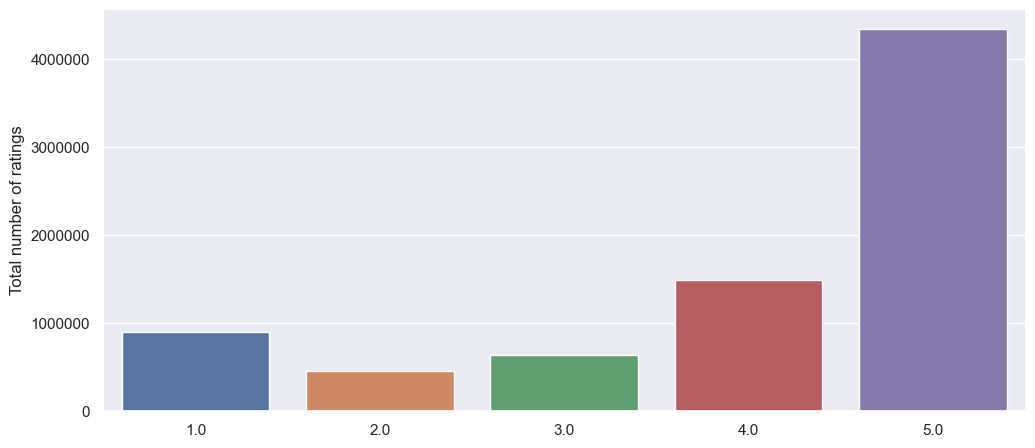

In [11]:
# the descriptive statistics show that the values of the rating column range from 1 to 5
# the mean is around 4 which suggests that most the of the ratings are 4s and 5s 
# in order to have a clearer insight about this column we need to plot its distribution
with sns.axes_style(style = 'darkgrid'):
  g = sns.catplot(x = 'Rating', data = data, aspect = 2.0, kind = 'count')
  g.set(xlabel = None, ylabel = 'Total number of ratings')
  plt.ticklabel_format(style = 'plain', axis = 'y') # suppress scientific notation in the y-axis 

*Observation:*  
The plot above shows the distribution of the rating attribute. We can see that the majority of the products have a 5 star rating followed by 4. 

**Preprocess the data**  
First, we can get rid of the timestamp column as we don't need to use it. Then, what we can do is to take a subset of the dataset in order to make it less sparse/denser. For example, we can only keep the users who have given 50 or more number of ratings. After that, we split the dataset into train and test sets. 

In [12]:
# remove the "Timestamp" column
data.drop('Timestamp', axis = 1, inplace = True)
data.head()

,UserID,ProductID,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [13]:
# take a subset of the data to make it less sparse/denser
# this reduces the dimensionality of the dataset and avoids running into memory error

# first we need to group the dataset by "UserID" and count the number of occurences of each user
data_grouped = data.groupby('UserID').size()

# then we filter the grouped data to discard all counts lower than 50
data_filtered = data_grouped[data.groupby('UserID').size() >= 50]

# retrieve the indices of the filtered data
indices = data_filtered.index

# finally, use these indices to filter the original data to keep only the users with 50 or more number of ratings
data_final = data[data.UserID.isin(indices)]
data_final.reset_index(drop = True, inplace = True)
data_final.head()

,UserID,ProductID,Rating
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [14]:
# print shapes of both the original and final data
print('data.shape:', data.shape, '\ndata_final.shape:', data_final.shape)

data.shape: (7824482, 3) 
data_final.shape: (125871, 3)


*Observation:*  
As we can see the number of observations was reduced from 7824482 to 125871 observations as we took a subset of the original dataset to keep only the users who have given 50 number of ratings or more. Hence, we now have a final dataset that is less sparse/denser.


**Split the final dataset into train and test sets**

In [15]:
# split the dataset into train and test sets with a ratio of 70:30
train_data, test_data = train_test_split(data_final, test_size = 0.3, random_state = 0)

# print the shape of both train and test sets
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

Shape of train data: (88109, 3)
Shape of test data: (37762, 3)


**Build a popularity-based recommender system**

In [16]:
# count the number of user ids per product
train_data_score = data_final.groupby('ProductID').agg({'UserID':'count'})

# rename the "UserID" column to "Score"
train_data_score.rename(columns = {'UserID':'Score'}, inplace = True)

# reset the indices
train_data_score.reset_index(inplace = True)

# sort the values of the "Score" column in descending order
train_data_score.sort_values(['Score', 'ProductID'], ascending = [0,1], inplace = True)

# add a rank column 
train_data_score['rank'] = train_data_score['Score'].rank(method = 'first', ascending = False)
train_data_score.head()

,ProductID,Score,rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [17]:
# create a function that recommends the top n products for a given user
def pop_reco_sys(userid, num_recommendations):
  user_recommendations = train_data_score
  # add a user id column to the dataframe
  user_recommendations['UserID'] = userid
  # move the "UserID" column to the first position
  col = user_recommendations.columns.tolist()
  col = col[-1:] + col[:-1]
  user_recommendations = user_recommendations[col]
  # get the top n products to recommend for the user
  user_recommendations = user_recommendations.head(num_recommendations)
  return user_recommendations

In [18]:
# test the function and recommend the top 5 products for 3 users
userid = ['A1E1LEVQ9VQNK', 'A3AYSYSLHU26U9', 'A3CLWR1UUZT6TG']
for i in userid:
  print('\nThe top 5 products to recommend for user (UserID:{})\n'.format(i))
  print(pop_reco_sys(i, 5))


The top 5 products to recommend for user (UserID:A1E1LEVQ9VQNK)

              UserID   ProductID  Score  rank
39003  A1E1LEVQ9VQNK  B0088CJT4U    206   1.0
24827  A1E1LEVQ9VQNK  B003ES5ZUU    184   2.0
11078  A1E1LEVQ9VQNK  B000N99BBC    167   3.0
38250  A1E1LEVQ9VQNK  B007WTAJTO    164   4.0
38615  A1E1LEVQ9VQNK  B00829TIEK    149   5.0

The top 5 products to recommend for user (UserID:A3AYSYSLHU26U9)

               UserID   ProductID  Score  rank
39003  A3AYSYSLHU26U9  B0088CJT4U    206   1.0
24827  A3AYSYSLHU26U9  B003ES5ZUU    184   2.0
11078  A3AYSYSLHU26U9  B000N99BBC    167   3.0
38250  A3AYSYSLHU26U9  B007WTAJTO    164   4.0
38615  A3AYSYSLHU26U9  B00829TIEK    149   5.0

The top 5 products to recommend for user (UserID:A3CLWR1UUZT6TG)

               UserID   ProductID  Score  rank
39003  A3CLWR1UUZT6TG  B0088CJT4U    206   1.0
24827  A3CLWR1UUZT6TG  B003ES5ZUU    184   2.0
11078  A3CLWR1UUZT6TG  B000N99BBC    167   3.0
38250  A3CLWR1UUZT6TG  B007WTAJTO    164   4.0
38615  

*Comment:*  
Since this is a recommender system based on popularity, the same products are recommended for all users. Hence, this is a non personalized recommender system.

**Build a collaborative filtering based recommender system**

We will create a pivot table in which each user id will correspond to a row and each product id will correspond to a column. The density of this matrix will be calculated. Finally, for the predictions the SVD method will be used.   

In [19]:
# make a pivot table to reorganize the data
df_pivot = data_final.pivot(index = 'UserID', columns = 'ProductID', values = 'Rating')
df_pivot.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10AFVU66A79Y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# the first thing that can be noticed is the null values contained in the pivot table
df_pivot.isnull().sum().sum()

74086729

In [21]:
# as we can see the dataframe contains so many null values
# let's fill these null values with 0s
df_pivot = df_pivot.fillna(0)
df_pivot.head() 

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# now we can calculate the density of the matrix (pivot table)
# print the shape of the dataframe
print('Shape of the pivot table:', df_pivot.shape)

# first we calculate the number of given ratings
number_ratings = np.count_nonzero(df_pivot)
print('The number of non zero ratings is: {}'.format(number_ratings))

# then we calculate the number of all possible ratings
number_all_ratings = df_pivot.shape[0] * df_pivot.shape[1]
print('The number of all possible ratings is: {}'.format(number_all_ratings))

# calculate density
density = (number_ratings / number_all_ratings) * 100
print('The density of the matrix (pivot table) is: {}%'.format(round(density, 2)))

Shape of the pivot table: (1540, 48190)
The number of non zero ratings is: 125871
The number of all possible ratings is: 74212600
The density of the matrix (pivot table) is: 0.17%


In [23]:
# add an index column named "user_index"
df_pivot['user_index'] = np.arange(0, df_pivot.shape[0], 1)

# set the index using the new column 
df_pivot.set_index(['user_index'], inplace = True)
df_pivot.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition
# SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), 
# used in document retrieval and word similarity in Text mining
u, s, vT = svds(df_pivot.to_numpy(), k = 10)

# set the diagonal matrix s containing the square roots of eigenvalues from u or v
s = np.diag(s)

# the predictions are the product of the 3 matrices u, s and vT
preds = np.dot(u, np.dot(s,vT))

# convert the matrix "preds" into a dataframe
df_preds = pd.DataFrame(data = preds, columns = df_pivot.columns)

# display the first few rows of the dataframe containing the predictions
df_preds.head() 

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [25]:
# create a function that recommends the top n products for a given user
def cf_reco_sys(userid, df_pivot, df_preds, num_recommendations):
  user_index = userid - 1 # the index starts at 0
  # sort original ratings in descending order
  original_user_ratings = df_pivot.iloc[user_index].sort_values(ascending = False)
  # sort predicted ratings in dscending order
  predicted_user_ratings = df_preds.iloc[user_index].sort_values(ascending = False)
  # concatenate the two series into a dataframe
  df_temp = pd.concat([original_user_ratings, predicted_user_ratings], axis = 1)
  # rename the columns
  df_temp.columns = ['original_user_ratings', 'predicted_user_ratings']
  # add a column that contains the product ids, set it as an index
  df_temp['recommended_products'] = df_pivot.columns
  df_temp.set_index(['recommended_products'], inplace = True)
  # filter on the original user ratings that are equal to 0
  df_temp = df_temp[df_temp.original_user_ratings == 0]
  # sort the "predicted_user_ratings" column in descending order
  df_temp.sort_values(by = ['predicted_user_ratings', 'original_user_ratings'], ascending = [0,1], inplace = True)
  # get the top n recommended products
  recommendations = df_temp.head(num_recommendations)
  return recommendations

In [26]:
# test the function
userid = [15, 25, 30]
for i in userid:
  print('\nThe top 5 products to recommend for user (UserID:{})\n'.format(i))
  print(cf_reco_sys(i, df_pivot, df_preds, 5))


The top 5 products to recommend for user (UserID:15)

                      original_user_ratings  predicted_user_ratings
recommended_products                                               
B001Q3M4IQ                              0.0                0.247331
B000BVNOZG                              0.0                0.196123
B009X2OS5Y                              0.0                0.133789
B008KRLZCW                              0.0                0.112403
B0047FLBV6                              0.0                0.111686

The top 5 products to recommend for user (UserID:25)

                      original_user_ratings  predicted_user_ratings
recommended_products                                               
B001PPVXPK                              0.0                0.890082
B000BV9HR0                              0.0                0.839816
B009X1LQ78                              0.0                0.536234
B0047E8DN6                              0.0                0.437834
B008KR

**Evaluate the model**

In [29]:
# calculate the means of "df_pivot" and "df_preds" tables
df_pivot_means = df_pivot.mean()
df_preds_means = df_preds.mean()

# calculate rmse
rmse = round((((df_pivot_means - df_preds_means)**2).mean())**0.5, 5)
rmse

0.0033

**Conclusion:**  
Model-based Collaborative Filtering is a personalized recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalized and the recommendations are based on frequecy counts, which may be not suitable to the user. We can see the difference above from the two created models: the popularity based model has recommended the same set of 5 products to all users but collaborative filtering based model has recommended an entire different list to every different user based on the user past purchase history.